In [1]:
import numpy as np
import torch
print(torch.__version__)

from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

2.0.1+cu118


In [2]:
from utils import eval_model, train, smooth, save_model, load_model, model_params, eval_plots, set_random_seed, eval_model_conf
from dataset_utils import extract_frames

In [3]:
set_random_seed(420)

In [4]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

import os
import shutil

In [5]:
# choose device to be used depending on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### download dataset and unzip

use preloaded from google drive

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%shell
mkdir KTH
mkdir KTH/data
mkdir KTH/data/videos

unzip /content/gdrive/MyDrive/KTH/videos/boxing.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/handclapping.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/handwaving.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/jogging.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/running.zip -d KTH/data/videos
unzip /content/gdrive/MyDrive/KTH/videos/walking.zip -d KTH/data/videos

wget -O sequences_list.txt http://www.csc.kth.se/cvap/actions/00sequences.txt


Archive:  /content/gdrive/MyDrive/KTH/videos/boxing.zip
  inflating: KTH/data/videos/person01_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person01_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person02_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/person03_boxing_d4_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d1_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d2_uncomp.avi  
  inflating: KTH/data/videos/person04_boxing_d3_uncomp.avi  
  inflating: KTH/data/videos/

### directly download and unzip

In [ ]:
"""
%%shell
mkdir KTH
mkdir KTH/data
mkdir KTH/data/videos

wget -O KTH/data/videos/boxing.zip http://www.csc.kth.se/cvap/actions/boxing.zip
wget -O KTH/data/videos/handclapping.zip http://www.csc.kth.se/cvap/actions/handclapping.zip
wget -O KTH/data/videos/handwaving.zip http://www.csc.kth.se/cvap/actions/handwaving.zip
wget -O KTH/data/videos/jogging.zip http://www.csc.kth.se/cvap/actions/jogging.zip
wget -O KTH/data/videos/running.zip http://www.csc.kth.se/cvap/actions/running.zip
wget -O KTH/data/videos/walking.zip http://www.csc.kth.se/cvap/actions/walking.zip

unzip KTH/data/videos/boxing.zip -d KTH/data/videos
unzip KTH/data/videos/handclapping.zip -d KTH/data/videos
unzip KTH/data/videos/handwaving.zip -d KTH/data/videos
unzip KTH/data/videos/jogging.zip -d KTH/data/videos
unzip KTH/data/videos/running.zip -d KTH/data/videos
unzip KTH/data/videos/walking.zip -d KTH/data/videos

rm KTH/data/videos/*.zip
"""

'\n%%shell\nmkdir KTH\nmkdir KTH/data\nmkdir KTH/data/videos\n\nwget -O KTH/data/videos/boxing.zip http://www.csc.kth.se/cvap/actions/boxing.zip\nwget -O KTH/data/videos/handclapping.zip http://www.csc.kth.se/cvap/actions/handclapping.zip\nwget -O KTH/data/videos/handwaving.zip http://www.csc.kth.se/cvap/actions/handwaving.zip\nwget -O KTH/data/videos/jogging.zip http://www.csc.kth.se/cvap/actions/jogging.zip\nwget -O KTH/data/videos/running.zip http://www.csc.kth.se/cvap/actions/running.zip\nwget -O KTH/data/videos/walking.zip http://www.csc.kth.se/cvap/actions/walking.zip\n\nunzip KTH/data/videos/boxing.zip -d KTH/data/videos\nunzip KTH/data/videos/handclapping.zip -d KTH/data/videos\nunzip KTH/data/videos/handwaving.zip -d KTH/data/videos\nunzip KTH/data/videos/jogging.zip -d KTH/data/videos\nunzip KTH/data/videos/running.zip -d KTH/data/videos\nunzip KTH/data/videos/walking.zip -d KTH/data/videos\n\nrm KTH/data/videos/*.zip\n'

In [9]:
extract_frames('KTH')

Completed till video :  50
Completed till video :  100
Completed till video :  150
Completed till video :  200
Completed till video :  250
Completed till video :  300
Completed till video :  350
Completed till video :  400
Completed till video :  450
Completed till video :  500
Completed till video :  550
[MESSAGE]	Frames extracted from all videos
[ERROR]:  KTH/data/VALIDATION/person01_boxing_d4_frame_246_370
Completed till video :  50
Completed till video :  100
Completed till video :  150
Completed till video :  200
Completed till video :  250
-----------------------------------------------------------
[ERROR MESSAGE]: 
limits :  ['*missing*']
seq_path :  KTH/data/TRAIN/person13_handclapping_d2_frame_401_523
-----------------------------------------------------------
Completed till video :  300
Completed till video :  350
Completed till video :  400
Completed till video :  450
Completed till video :  500
Completed till video :  550
Completed till video :  600
[ALERT]		Total error cou

### dataset class

In [10]:
import os
import random
from PIL import Image

class KTH_dataset(torch.utils.data.Dataset):

  def __init__(self, DATA_PATH,  transforms = None, mode = 'TRAIN', instance_len = 20):
    self.instances = []
    self.inst_class = []
    self.path = DATA_PATH
    self.mode = mode
    self.transforms = transforms
    self.instance_len = instance_len

    self.mapping = {'boxing':0, 'handclapping':1, 'handwaving':2, 'jogging':3, 'running':4, 'walking':5}

    all_vids = os.listdir(self.path + '/' + self.mode)

    # find all directories for wanted dataset part, and load all file names in these directories
    for vid in all_vids:
      frames = os.listdir(self.path + '/' + self.mode + '/' + vid)
      frames.sort() # sort to make sure that frames in correct order
      current_instance = []

      # split in parts of frames
      for i in range(int(len(frames)/self.instance_len)):
        current_instance = frames[i*self.instance_len: i*self.instance_len + self.instance_len]

        current_instance = [(self.path + '/' + self.mode + '/' + vid + '/' + item) for item in current_instance]

        self.instances.append(current_instance)

        self.inst_class.append(int(self.mapping[vid.split('_')[1]]))


  def __getitem__(self, x):
    instance_img = self.instances[x]
    label = torch.tensor(self.inst_class[x])

    tens_list = []

    # load image and transform to tensor to be able to apply other transforms directly
    for inst in instance_img:
      image = Image.open(inst).convert("RGB")
      inst_tensor = transforms.ToTensor()(image)
      tens_list.append(inst_tensor)
      
    inst_tensor = torch.stack(tens_list, dim=0)

    if self.transforms != None: # apply other transforms. is directly applied at once on all images/channels
      inst_tensor = self.transforms(inst_tensor)

    return inst_tensor, label

  def __len__(self):
    return len(self.instances)


In [10]:
"""
# only for testing of dataset class

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
               ])

dset = KTH_dataset('/content/KTH/data',  transforms = train_transforms, mode = 'TRAIN', instance_len = 30)
"""

### visualize one instance

label: running


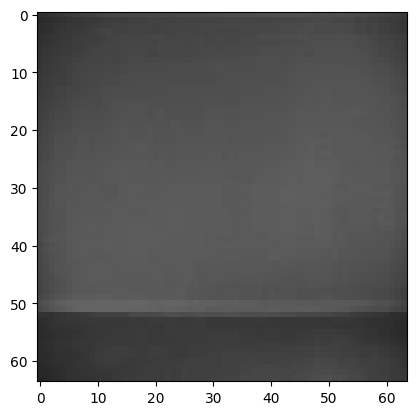

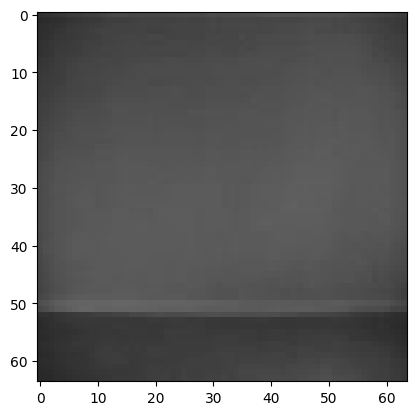

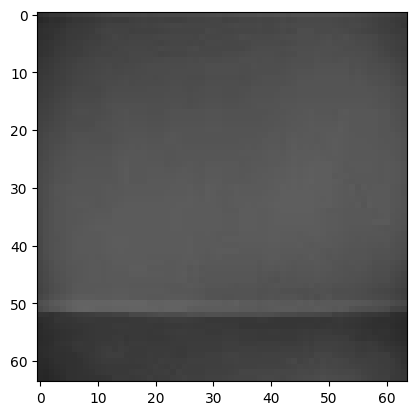

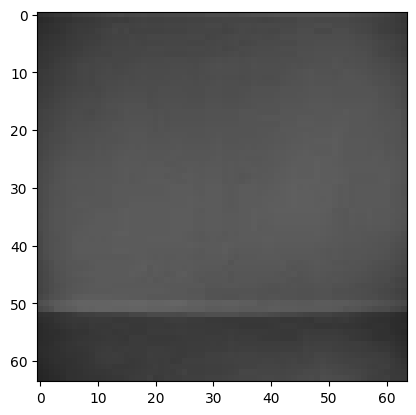

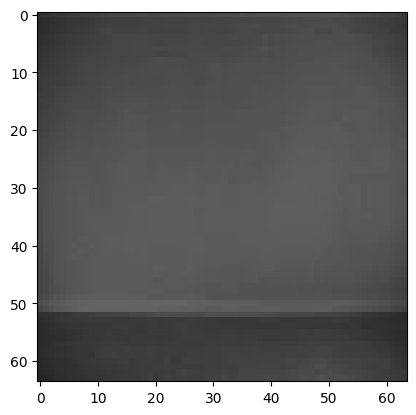

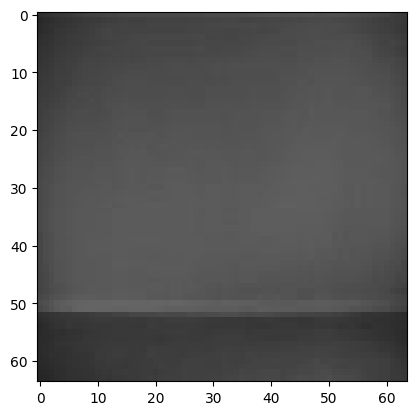

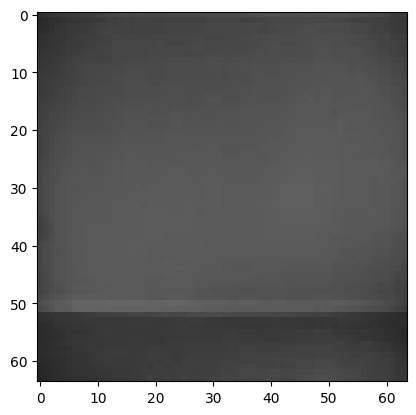

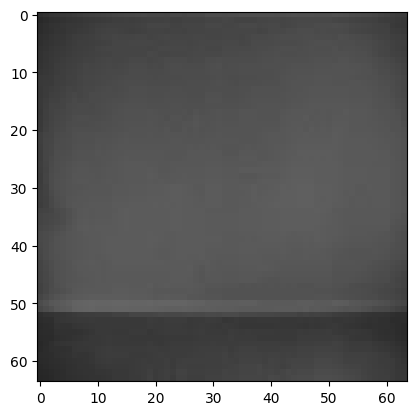

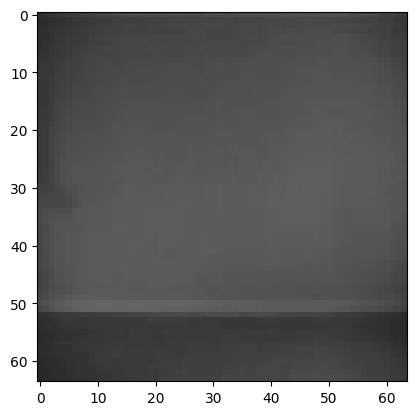

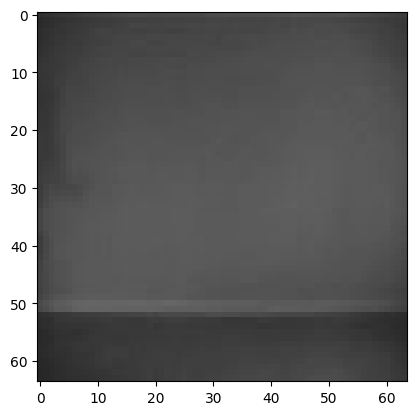

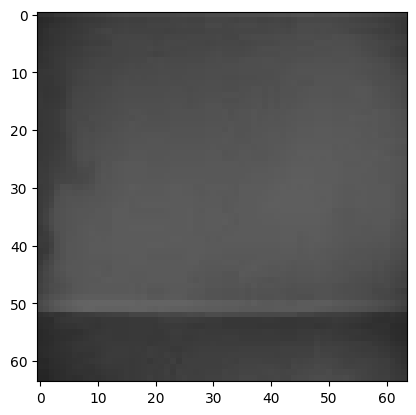

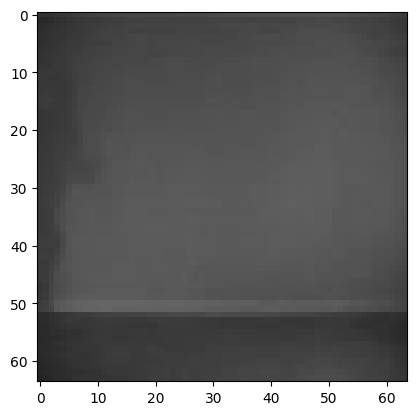

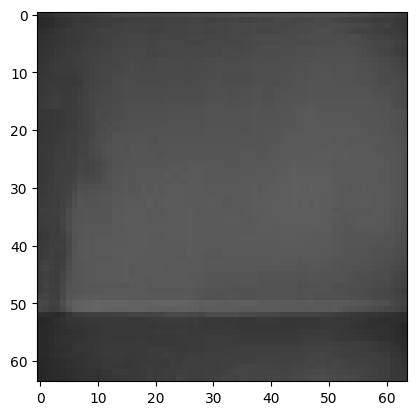

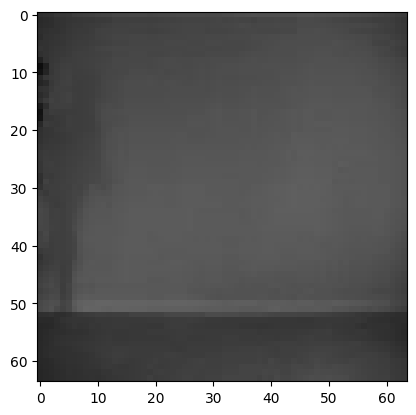

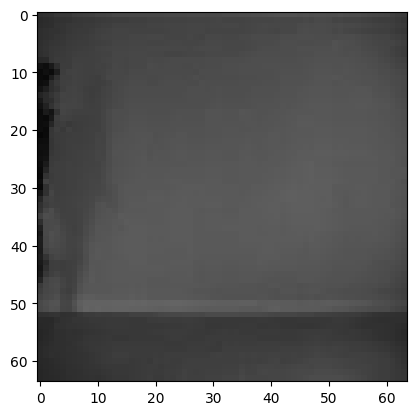

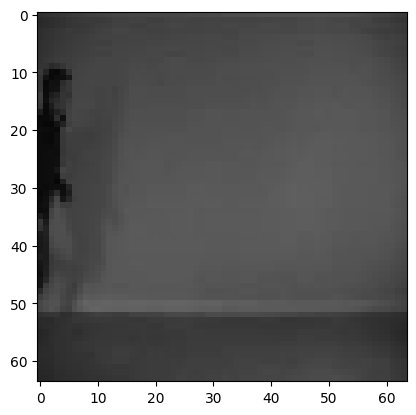

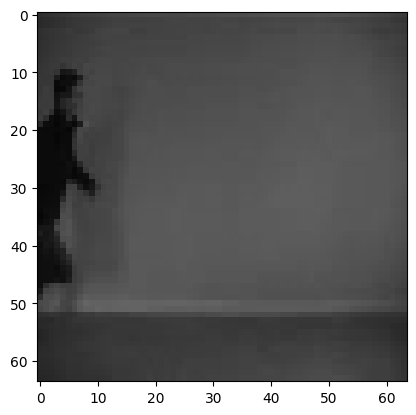

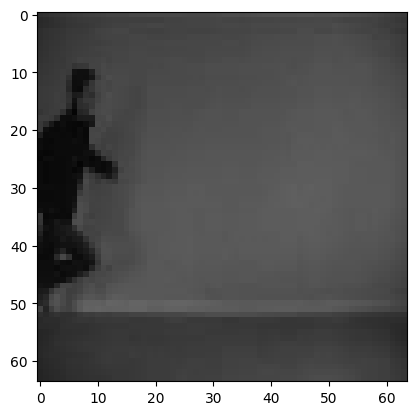

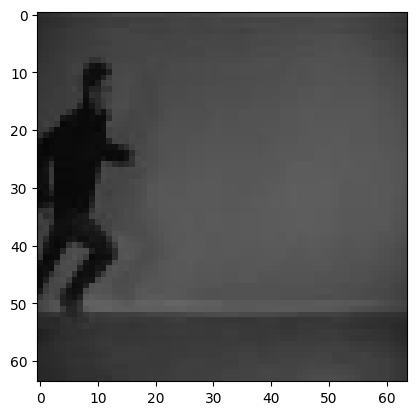

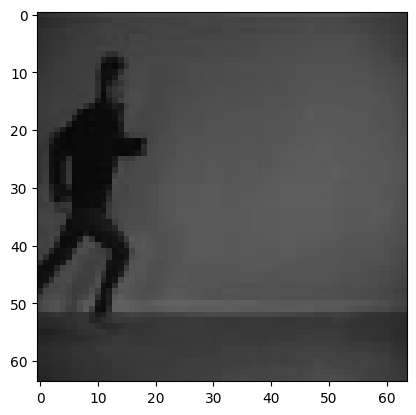

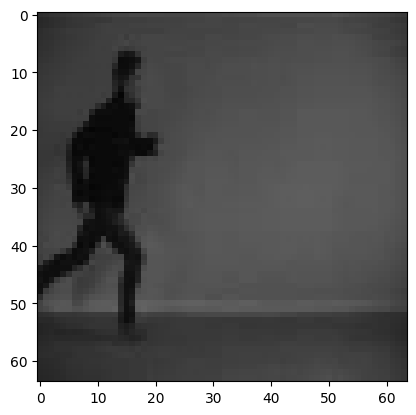

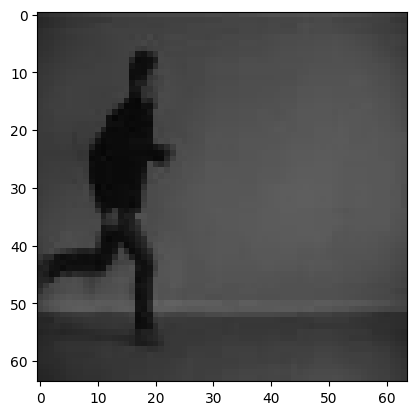

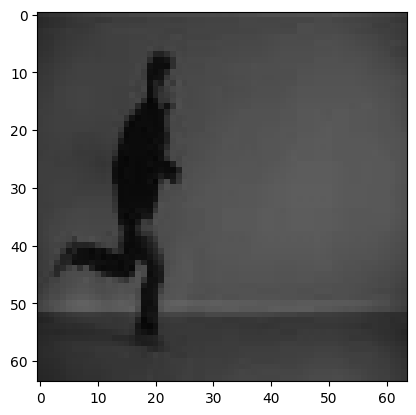

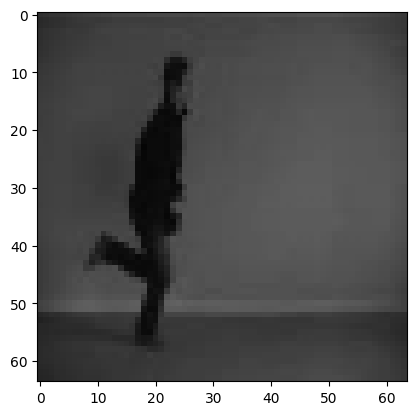

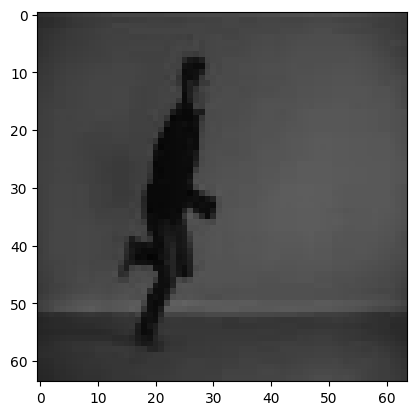

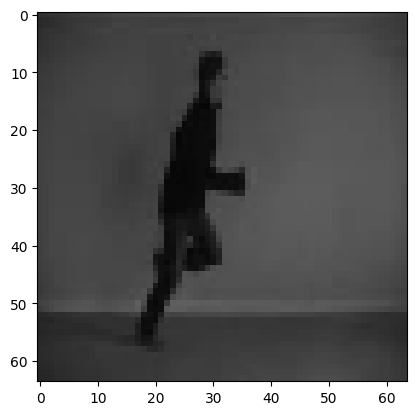

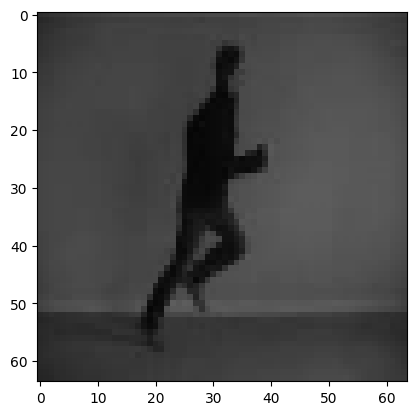

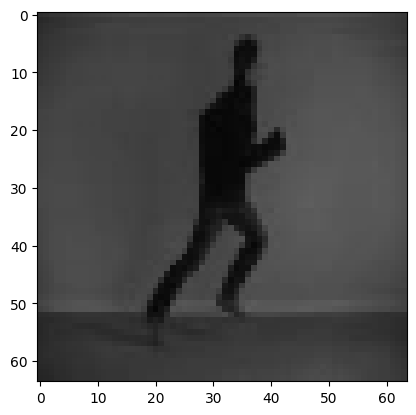

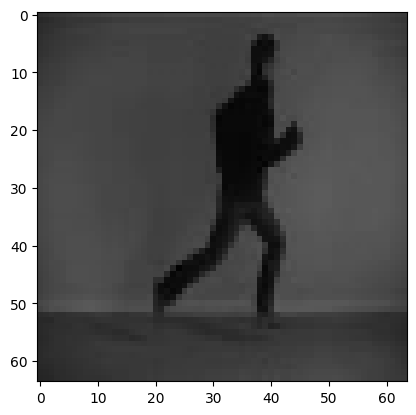

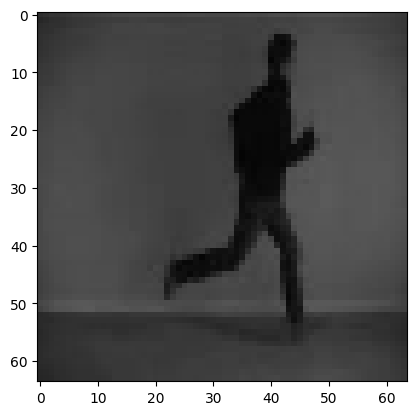

In [ ]:
from scipy.misc import face
import matplotlib.pyplot as plt
import torch

instance, label = dset.__getitem__(67)

#print(label.item())

rev_map = {0:'boxing', 1:'handclapping', 2:'handwaving', 3:'jogging', 4:'running', 5:'walking'}

print(f"label: {rev_map[label.item()]}")
#print(instance.shape)

for i in range(instance.shape[0]):
  plt.imshow(transforms.functional.to_pil_image(instance[i,:,:,:]))
  plt.show()



### code for LSTM layer

In [11]:
import torch.nn as nn

# code for a lstm unit (cell)
class convCLSTM(nn.Module):
  """
  kernel size: size of all kernels in all conv layers
  in channels: number of channels for input images
  out channels: number of channels of output/hidden unit
  input size: size of input images
  full_h: describes if only last output of lstm is returned or all outputs
  """
  def __init__(self, kernel_size = 3, in_channels = 3, out_channels = 13, input_size = (16,16), full_h = False): 
    super().__init__()

    self.full_h = full_h
    self.input_size = input_size
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size

    # layers according to definition lf lstm
    # dense layers replaced by convolutional layers
    self.ft_c = nn.Sequential(
          nn.Conv2d(self.in_channels + self.out_channels, self.out_channels, self.kernel_size, padding=int(self.kernel_size/2)),
          nn.Sigmoid(),
          )
    
    self.it_c = nn.Sequential(
          nn.Conv2d(self.in_channels + self.out_channels, self.out_channels, self.kernel_size, padding=int(self.kernel_size/2)),
          nn.Sigmoid(),
          )
    
    self.C_hat_c = nn.Sequential(
          nn.Conv2d(self.in_channels + self.out_channels, self.out_channels, self.kernel_size, padding=int(self.kernel_size/2)),
          nn.Tanh(),
          )
    
    self.ot_c = nn.Sequential(
          nn.Conv2d(self.in_channels + self.out_channels, self.out_channels, self.kernel_size, padding=int(self.kernel_size/2)),
          nn.Sigmoid(),
          )

    return

  # calculate according to definition of lstm (for one input image)
  def apply_once(self, instance, h, c):
    input = torch.cat([h,instance], dim = 1)
    ft = self.ft_c(input)
    it = self.it_c(input)
    C_hat = self.C_hat_c(input)
    ot = self.ot_c(input)
    ct = ft*c + it*C_hat
    ht = ot * nn.Tanh()(c)

    return ht, ct

  # function to forward a full instance (e.g. 30 frames) through the network
  def forward(self, x):
    instances, h, c = x 

    b_size, n_frames, n_channels, n_rows, n_cols = instances.shape
    # stack c and h to be able to use batches
    c_stacked = c.repeat(b_size,1,1,1) # vector which is batch size times c stacked
    h_stacked = h.repeat(b_size,1,1,1)  # tensor with batch size copied start of h

    h_l = [h_stacked]
    c_l = [c_stacked]

    for i in range(instances.shape[1]):
      # extract wanted frame and reshape to apply convolutions
      input = instances[:,i,:,:,:].reshape((b_size, n_channels, n_rows, n_cols)) 
      # apply lstm once and save h
      ht, ct = self.apply_once(input, h_l[-1], c_l[-1])

      h_l.append(ht)
      c_l.append(ct)

    out = h_l[-1]

    if self.full_h:
      out = torch.stack(h_l[1:len(h_l)])  # dont take init value for h in output
      out = out.reshape((b_size, -1, out.shape[2], n_rows, n_cols))

    return out

# class for full lstm module (uses class above)
class CLSTM(nn.Module):

  def __init__(self, emb_dims, emb_out_channels, num_layers=1, kernel_size = 3): 
    super().__init__()

    self.emb_dims = emb_dims
    self.emb_out_channels = emb_out_channels
    self.num_layers = num_layers
    self.kernel_size = kernel_size

    # according to wanted number of layers create cells (from above)
    lstms = []
    for i in range(self.num_layers): 
        in_size = self.emb_dims[0] if i == 0 else self.emb_out_channels
        fl_h = False if i == self.num_layers - 1 else True
        lstms.append(convCLSTM(kernel_size = self.kernel_size, in_channels = in_size, out_channels = self.emb_out_channels, input_size = (self.emb_dims[1], self.emb_dims[2]), full_h = fl_h))

    self.lstms = nn.ModuleList(lstms)


    return

  # apply lstms according to number of layers of lstms
  def forward(self, x):
    instances, h, c = x 

    b_size, n_frames, n_channels, n_rows, n_cols = instances.shape

    for i in range(self.num_layers):
          out = self.lstms[i]((instances, h[i], c[i])) #instances, h, c
          instances = out

    return out

## definition of full model

In [14]:
# definition of full recurrent model using defined lstm layer
class OurSequentialModel(nn.Module):
    """
    input_dims = (n_frames, n_channels, width, height)
    emb_dims = (n_channels, widht, height)
    emb_out_channels = wanten # output channels
    num_layers = number of lstm cells 
    """
    def __init__(self, input_dims, emb_dims, emb_out_channels, output_features, num_layers=1, kernel_size = 3, device = 'cpu'):
        super().__init__()

        self.input_dims = input_dims
        self.emb_dims = emb_dims
        self.emb_out_channels = emb_out_channels
        self.output_features = output_features
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        
        # save number of h and c according to number of lstm layers (parameters are learned)
        h = []
        c = []
        for i in range(num_layers):
          h.append(nn.Parameter(
                torch.randn(self.emb_out_channels, self.emb_dims[1], self.emb_dims[2]).requires_grad_())
            )
          c.append(nn.Parameter(
                torch.randn(self.emb_out_channels, self.emb_dims[1], self.emb_dims[2]).requires_grad_())
            )
        self.h = nn.ParameterList(h)
        self.c = nn.ParameterList(c)


        # embedding cnn
        # use 3d convolution with size 1 in depth to be able to apply convolution on all frames simultaneously
        # is the same as applying 2dconvolutions on all frames one after another
        self.encoder = nn.Sequential(
          nn.Conv3d(in_channels=self.input_dims[1], out_channels=16, kernel_size = (1,self.kernel_size,self.kernel_size), stride=(1,1,1), padding = (0,int(self.kernel_size/2),int(self.kernel_size/2))),
          nn.ReLU(),
          nn.MaxPool3d((1,2,2), stride=(1,2,2)),
          nn.Dropout(p=0.5),
          nn.Conv3d(in_channels=16, out_channels=self.emb_dims[0], kernel_size = (1,self.kernel_size,self.kernel_size), stride=(1,1,1), padding = (0,int(self.kernel_size/2),int(self.kernel_size/2))),
          nn.ReLU(),
          nn.MaxPool3d((1,2,2), stride=(1,2,2)),
          nn.Dropout(p=0.5),
          )
        # LSTM layers
        self.lstm = CLSTM(emb_dims, emb_out_channels, num_layers=num_layers, kernel_size = 3)

        n_out_features = int(self.emb_dims[1] * self.emb_dims[2] * self.emb_out_channels)

        # classifier
        self.classifier = nn.Sequential(
          nn.Dropout(p=0.5),
          nn.Linear(in_features=n_out_features, out_features=64),
          nn.ReLU(),
          nn.Linear(in_features=64, out_features=self.output_features),
          )
        
        return
    
    def forward(self, x):
        b_size, n_frames, n_channels, n_rows, n_cols = x.shape

        x_t = x.transpose(1,2) # transpose to be able to use conv3d and maxpool 3d correctly
        # apply encoder
        out = self.encoder(x_t)

        out = out.transpose(1,2)  # transpose for lstm layers
        # apply lstm
        out = self.lstm((out, self.h, self.c))

        out = out.view(b_size, -1)  # reshape to classify
        # classifying
        out = self.classifier(out) 

        return out
    

test dimensions of model

In [15]:
tmodel = OurSequentialModel(input_dims = (20, 3,64,64), emb_dims = (24,16,16), emb_out_channels = 24, output_features = 6, num_layers=2, kernel_size = 3, device = 'cpu')

"""
input_dims = (n_frames, n_channels, width, height)
emb_dims = (n_channels, widht, height)
emb_out_channels = wanten # output channels
num_layers = number of lstm cells 
"""

in_test = torch.ones((32,20,3,64,64))   

out = tmodel.forward(in_test)

print(out.shape)

torch.Size([32, 6])


## train models and test them

In [11]:
train_transforms = transforms.Compose([
               transforms.RandomHorizontalFlip(p=0.5),
               transforms.RandomRotation(degrees=5),
               transforms.Resize((64, 64), antialias=True),
               ])

test_transforms = transforms.Compose([
               transforms.Resize((64, 64), antialias=True),
               ])

n_frames = 30


train_dataset = KTH_dataset('/content/KTH/data',  transforms = train_transforms, mode = 'TRAIN', instance_len = n_frames)
val_dataset = KTH_dataset('/content/KTH/data',  transforms = train_transforms, mode = 'VALIDATION', instance_len = n_frames)

# use validation set to train too, as we do not use it here in another way
train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])  

test_dataset = KTH_dataset('/content/KTH/data',  transforms = test_transforms, mode = 'TEST', instance_len = n_frames)


print(f"Train samples: {len(train_dataset)}")
#print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 4219
Test samples: 2248


Distribution of classes in dataset

In [ ]:
"""
labels = []

for i in tqdm(range(len(test_dataset))):
  instance, label = test_dataset.__getitem__(i)
  labels.append(label.item())

labels = np.unique(np.asarray(labels), return_counts=True)

print(labels)
"""

100%|██████████| 2248/2248 [01:28<00:00, 25.38it/s]

(array([0, 1, 2, 3, 4, 5]), array([445, 430, 525, 247, 169, 432]))


In [ ]:
"""
labels = []

from tqdm import tqdm

for i in tqdm(range(len(train_dataset))):
  instance, label = train_dataset.__getitem__(i)
  labels.append(label.item())

labels = np.unique(np.asarray(labels), return_counts=True)

print(labels)
"""

100%|██████████| 4219/4219 [03:09<00:00, 22.21it/s]

(array([0, 1, 2, 3, 4, 5]), array([ 833,  789, 1000,  464,  300,  833]))


We can observe that the dataset is unbalanced. This probably happens, as the videos have different lengths. Classes 3,4 are underrepresented. (might lead to a worse result for these classes)

In [14]:
BATCH_SIZE = 32
SHUFFLE_TRAIN = True
NUM_EPOCHS = 14
LR = 3e-4
EVAL_FREQ = 1
SAVE_FREQ = 2


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## test our own implementation

In [26]:
conv_lstm = OurSequentialModel(input_dims = (n_frames, 3,64,64), emb_dims = (16,16,16), emb_out_channels = 16, output_features = 6, num_layers=2, kernel_size = 5, device = device)
conv_lstm.to(device)

OurSequentialModel(
  (h): ParameterList(
      (0): Parameter containing: [torch.float32 of size 16x16x16 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 16x16x16 (GPU 0)]
  )
  (c): ParameterList(
      (0): Parameter containing: [torch.float32 of size 16x16x16 (GPU 0)]
      (1): Parameter containing: [torch.float32 of size 16x16x16 (GPU 0)]
  )
  (encoder): Sequential(
    (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv3d(16, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (5): ReLU()
    (6): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
  )
  (lstm): CLSTM(
    (lstms): ModuleList(
      (0-1): 2 x convCLSTM(
        (ft_c): Sequential(
          (0): Conv2d(32, 16

In [27]:
print(f"The model has {model_params(conv_lstm)} parameters.")

The model has 323606 parameters.


In [28]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer0 = torch.optim.Adam(conv_lstm.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every X epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer0, step_size=14, gamma=0.2)

In [29]:
import time
start_time = time.time()
stats0, model0 = train(conv_lstm, NUM_EPOCHS, train_loader, None, val_loader, optimizer0, criterion, EVAL_FREQ, SAVE_FREQ, '/content', device, scheduler, twriter = None, loadpath = None, stats = None)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch -1: valid_loss 1.80530 valid_acc 10.99 | lr 0.0003


100%|██████████| 132/132 [03:23<00:00,  1.54s/it]


Epoch 1: train_loss 1.72485 | valid_loss 1.56664 valid_acc 36.39| lr 0.0003


100%|██████████| 132/132 [03:23<00:00,  1.54s/it]


Epoch 2: train_loss 1.34134 | valid_loss 1.35012 valid_acc 41.50| lr 0.0003


100%|██████████| 132/132 [03:14<00:00,  1.47s/it]


Epoch 3: train_loss 1.07772 | valid_loss 1.00502 valid_acc 52.98| lr 0.0003


100%|██████████| 132/132 [03:12<00:00,  1.46s/it]


Epoch 4: train_loss 0.91011 | valid_loss 0.85493 valid_acc 60.63| lr 0.0003


100%|██████████| 132/132 [03:12<00:00,  1.46s/it]


Epoch 5: train_loss 0.76429 | valid_loss 0.76806 valid_acc 68.10| lr 0.0003


100%|██████████| 132/132 [03:09<00:00,  1.44s/it]


Epoch 6: train_loss 0.63314 | valid_loss 0.77131 valid_acc 67.57| lr 0.0003


100%|██████████| 132/132 [03:09<00:00,  1.44s/it]


Epoch 7: train_loss 0.55843 | valid_loss 0.66654 valid_acc 74.15| lr 0.0003


100%|██████████| 132/132 [03:15<00:00,  1.48s/it]


Epoch 8: train_loss 0.49825 | valid_loss 0.72175 valid_acc 72.91| lr 0.0003


100%|██████████| 132/132 [03:39<00:00,  1.67s/it]


Epoch 9: train_loss 0.44787 | valid_loss 0.68198 valid_acc 73.04| lr 0.0003


100%|██████████| 132/132 [03:41<00:00,  1.68s/it]


Epoch 10: train_loss 0.40921 | valid_loss 0.62658 valid_acc 77.00| lr 0.0003


100%|██████████| 132/132 [03:33<00:00,  1.61s/it]


Epoch 11: train_loss 0.39243 | valid_loss 0.67700 valid_acc 75.40| lr 0.0003


100%|██████████| 132/132 [03:10<00:00,  1.44s/it]


Epoch 12: train_loss 0.37346 | valid_loss 0.60547 valid_acc 77.09| lr 0.0003


100%|██████████| 132/132 [03:05<00:00,  1.41s/it]


Epoch 13: train_loss 0.32973 | valid_loss 0.67991 valid_acc 76.91| lr 0.0003


100%|██████████| 132/132 [03:04<00:00,  1.40s/it]


Epoch 14: train_loss 0.30257 | valid_loss 0.65893 valid_acc 77.09| lr 0.0003
--- 3649.180330991745 seconds ---


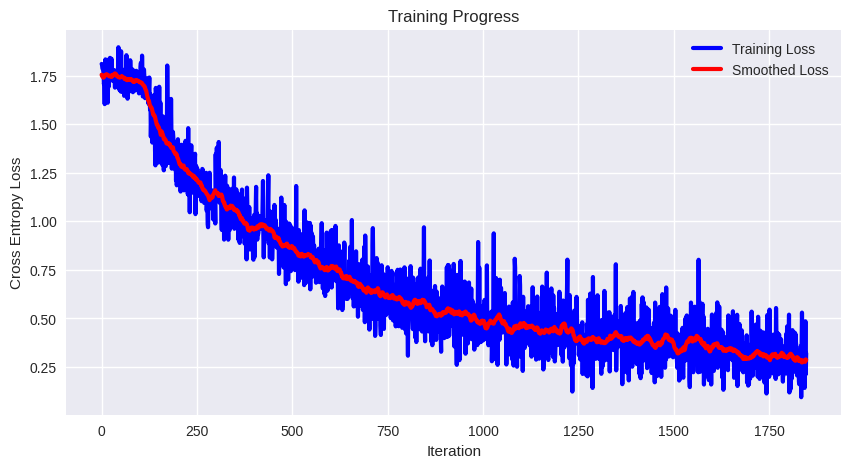

In [33]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

smooth_loss = smooth(stats0["per_batch_loss"], 31)
ax.plot(stats0["per_batch_loss"], c="blue", label="Training Loss", linewidth=3)#, alpha=0.5)
ax.plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax.legend(loc="best")
ax.set_xlabel("Iteration")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Training Progress")

plt.show()

> The loss curve is as one would expect. Steadily decreasing and converging towards 0 (looks like it) in the end.

Classification accuracy: 77.09%


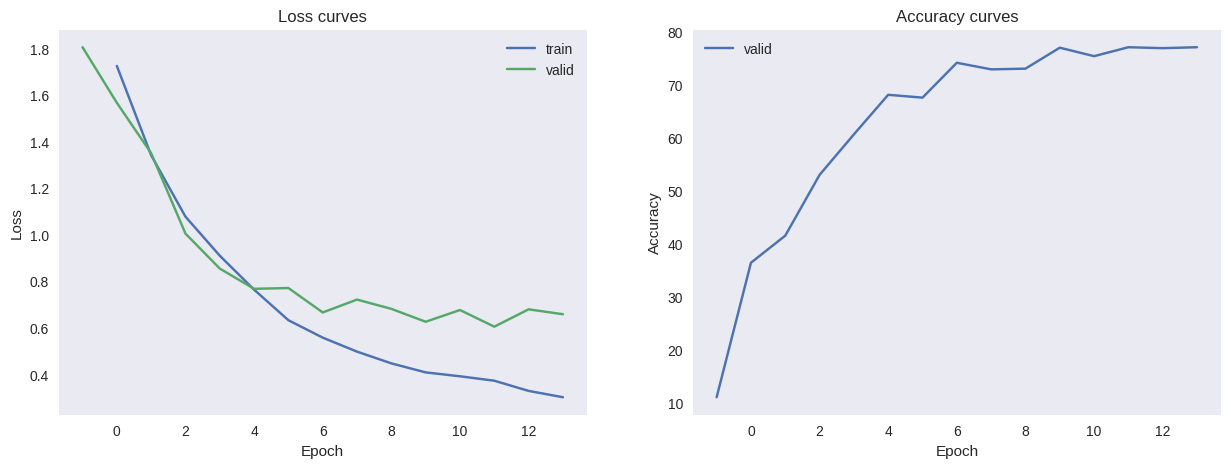

In [34]:
eval_plots(model0, val_loader, criterion, device, stats0)

> The validation loss and accuracy curve also look as expected. What can be observed is, that the validation loss decreases much slower in the end compared to the training loss. It looks like some overfitting takes place. From epoch 6 onward the accuracy also increases much slower than before. However it is still increasing slightly.

> The accuracy is lower than what we expected (for only 6 classes), however 77.09% is still quite high.

0:boxing, 1:handclapping, 2:handwaving, 3:jogging, 4:running, 5:walking
Test accuracy: 77.09%
F1 Score: 0.77%


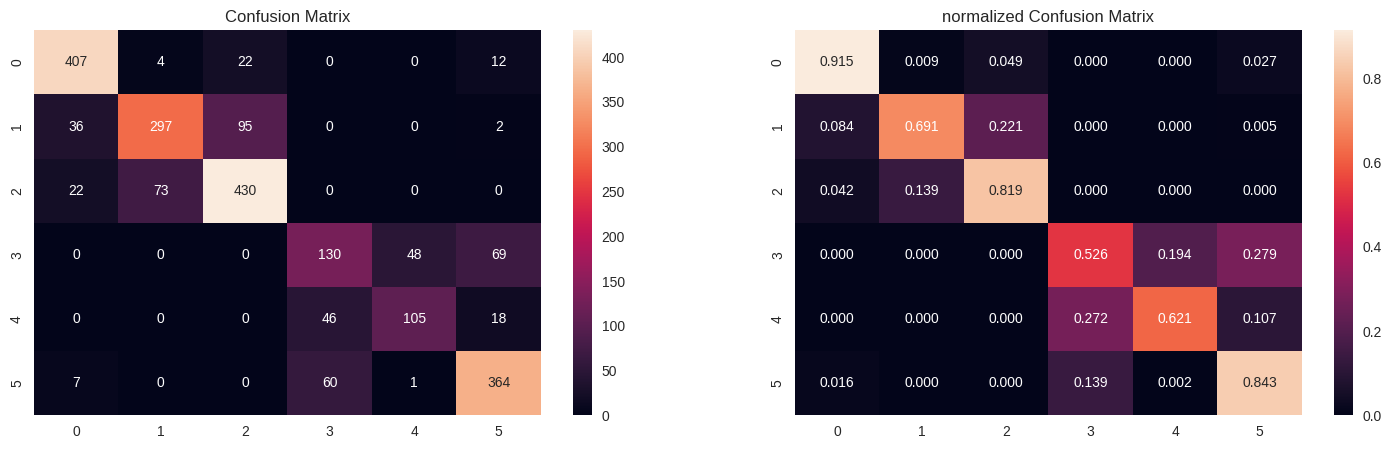

In [35]:
_, _, correct_labels, predicted_labels = eval_model_conf(model0, val_loader, criterion, device)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# calculate absolute confusion matrix
confusion_matr = confusion_matrix(correct_labels, predicted_labels)#, labels=[0,1,2,3,4,5,6,7,8,9])
df_confusion = pd.DataFrame(confusion_matr, range(confusion_matr.shape[0]), range(confusion_matr.shape[0]))
# calculate confusion matric normalized in rows
confusion_matr_norm = confusion_matrix(correct_labels, predicted_labels, normalize = 'true') #, labels=[0,1,2,3,4,5,6,7,8,9]
df_confusion_norm = pd.DataFrame(confusion_matr_norm, range(confusion_matr_norm.shape[0]), range(confusion_matr_norm.shape[0]))

print('0:boxing, 1:handclapping, 2:handwaving, 3:jogging, 4:running, 5:walking')

fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("True Label")
ax[0].set_title("Confusion Matrix")
sn.heatmap(df_confusion, annot=True, annot_kws={"size": 10}, fmt="d", ax=ax[0]) 


ax[1].set_xlabel("Prediction")
ax[1].set_ylabel("True Label")
ax[1].set_title("normalized Confusion Matrix")
sn.heatmap(df_confusion_norm, annot=True, annot_kws={"size": 10}, fmt=".3f", ax=ax[1]) 

acc = 0
for i in range(confusion_matr.shape[0]):
  acc = acc + confusion_matr[i,i]
acc = acc/confusion_matr.sum()*100
print(f"Test accuracy: {round(acc,2)}%")


print(f"F1 Score: {round(f1_score(correct_labels, predicted_labels, average='micro'),2)}")

>The F1 score is 0.77 (the % should not be there, but we cant change that anymore, as we would have to retrain the whole model).
Compared to the results from the paper "Interpreting Video Features: A Comparison of
3D Convolutional Networks and Convolutional
LSTM Networks" (https://openaccess.thecvf.com/content/ACCV2020/papers/Manttari_Interpreting_Video_Features_A_Comparison_of_3D_Convolutional_Networks_and_ACCV_2020_paper.pdf) which compares the performance of convolutional lstm and 3dCNNs, the F1 score for lstm is lower (0.77 to 0.84). However, it is not much lower. Also the number of model parameter of our model is much lower and it is much less optimized.

> The confusion matrix reflects the generally good result, with the highest values on the main diagonal. However there are some errors. For example classes handclapping and handwaving are confused sometimes. This might be the case, as the movement only uses the arms, and the body is static. Therefore they look similar. Also the classes jogging and walking and jogging and running are confused sometimes. This might be the case, as jogging and running and jogging and walking have similar speed and movement. Running and walking are not confused as often, probably because the speed is very different.